In [100]:
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset
import requests as rq
from io import BytesIO

In [101]:
sectors = pd.read_csv("../data/stocks/sectors.csv")
sectors = sectors[["표준코드", "단축코드", "상장일"]]

url_price = "http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd"

data_price = {
    "locale": "ko_KR",
    "tboxisuCd_finder_stkisu0_1": "005930/삼성전자",
    "isuCd": "KR7005930003",
    "isuCd2": "KR7005930003",
    "codeNmisuCd_finder_stkisu0_1": "삼성전자",
    "param1isuCd_finder_stkisu0_1": "ALL",
    "strtDd": "19750611",
    "endDd": "20250319",
    "adjStkPrc_check": "Y",
    "adjStkPrc": "2",
    "share": "1",
    "money": "1",
    "csvxls_isNo": "false",
    "name": "fileDown",
    "url": "dbms/MDC/STAT/standard/MDCSTAT01701"
}

headers = {
    "Referer": "http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36"
}

otp_indv = rq.post(url_price, data_price, headers=headers).text

indv_down_url = "http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd"

# 서버로부터 데이터 요청 후 읽어들이기
indv_down = rq.post(url=indv_down_url, data={"code": otp_indv}, headers=headers)
indv_price = pd.read_csv(BytesIO(indv_down.content), encoding="EUC-KR")

In [102]:
indv_price.to_csv("../data/stocks/삼성전자.csv")

In [103]:
data = pd.read_csv("../data/stocks/삼성전자.csv")
data.head()

,Unnamed: 0,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,0,2025/03/19,58500,900,1.56,57400,59200,57400,29421759,1727220604750,346298818437000,5919637922
1,1,2025/03/18,57600,0,0.00,58800,59000,57300,28138594,1638462319270,340971144307200,5919637922
2,2,2025/03/17,57600,2900,5.30,55500,57800,55400,35559021,2036156585500,340971144307200,5919637922
3,3,2025/03/14,54700,0,0.00,54500,55100,54400,10845154,594158589200,323804194333400,5919637922
4,4,2025/03/13,54700,-200,-0.36,55800,55900,54200,24132151,1327792389578,323804194333400,5919637922


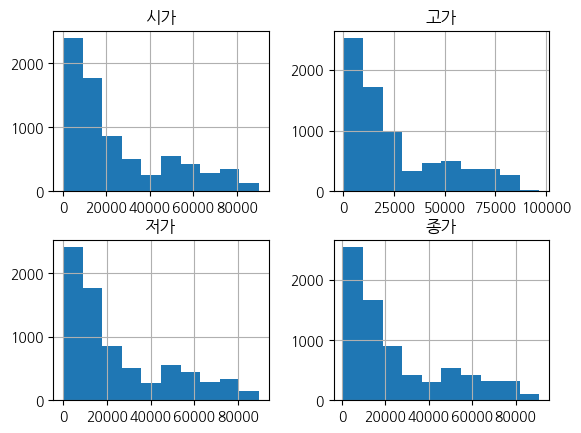

In [104]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

data_used = data.iloc[:, 5:8]
data_used["종가"] = data["종가"]
hist = data_used.hist()
plt.show()

In [ ]:
import numpy as np

from torch.utils.data.dataset import Dataset

class ECO(Dataset):
    def __init__(self):
       self.csv = pd.read_csv("../data/stocks/삼성전자.csv").sort_values(by="일자", ascending=True)

       # 입력 데이터 정규화
       self.data = self.csv.iloc[:-1, 2].values   # 종가를 제외한 데이터
       self.data = self.data / np.max(self.data)  # 0과 1 사이로 정규화

       # 종가 데이터 정규화
       self.label = self.csv.iloc[1:, 2].values       
       self.label = self.label / np.max(self.label)

    def __len__(self):
       return len(self.data) - 30
    
    def __getitem__(self, i):
       data = self.data[i:i+30]
       label = self.label[i+30]

       return data, label
    



In [156]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        # RNN층의 정의
        self.rnn = nn.RNN(input_size=1, hidden_size=8, num_layers=5,
                            batch_first=True)

        # 주가를 예측하는 MLP층 정의
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.Tanh() # 활성화 함수 정의
        
    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)  # RNN층의 출력

        # MLP층의 입력으로 사용되게 모양 변경
        x = torch.reshape(x, (x.shape[0], -1))

        # MLP층을 이용해 종가 예측
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # 예측한 종가를 1차원 벡터로 표현
        x = torch.flatten(x)

        return x
    

In [129]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델의 정의
dataset = ECO()       # 데이터셋의 정의

In [130]:
loader = DataLoader(dataset, batch_size=32)  # 배치 크기를 32로 설정
optim = Adam(params=model.parameters(), lr=0.0001) # 사용할 최적화 설정

In [131]:
data.shape[0]

1

In [132]:
data.type(torch.FloatTensor)

tensor([[[0.0170],
         [0.0172],
         [0.0172],
         [0.0166],
         [0.0166],
         [0.0160],
         [0.0157],
         [0.0155],
         [0.0158],
         [0.0151],
         [0.0153],
         [0.0158],
         [0.0160],
         [0.0161],
         [0.0161],
         [0.0161],
         [0.0160],
         [0.0161],
         [0.0163],
         [0.0160],
         [0.0158],
         [0.0158],
         [0.0163],
         [0.0161],
         [0.0166],
         [0.0170],
         [0.0172],
         [0.0173],
         [0.0174],
         [0.0175]]])

In [133]:
for epoch in range(200):
     iterator = tqdm.tqdm(loader)
     for data, label in iterator:
          data = data.type(torch.float32).to(device)
          label = label.type(torch.float32).to(device)

          # 초기 은닉 상태
          h0 = torch.zeros(5, data.size(0), 8).to(device)

          if data.dim() == 2:  # (batch_size, seq_len)
               data = data.unsqueeze(-1)

          optim.zero_grad()
     
          # 모델의 예측값
          pred = model(data, h0)

          # 손실의 계산
          loss = nn.MSELoss()(pred, label)
          loss.backward()  # 오차 역전파
          optim.step()     # 최적화 진행

          iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

epoch199 loss:0.0018768998561426997: 100%|██████████| 235/235 [00:03<00:00, 68.58it/s] 


In [166]:
dataset

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 30개의 데이터만 추출하여 새로운 데이터셋 생성
subset_data = dataset.data[-30:]
subset_label = dataset.label[-30:]


# 30개 데이터를 로드하는 DataLoader 생성
loader = DataLoader(subset_dataset, batch_size=1)

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
    # 모델의 가중치 불러오기
    model.load_state_dict(torch.load("rnn.pth", map_location=device))

    for data, label in loader:
        data = data.type(torch.float32).to(device)
        label = label.type(torch.float32).to(device)

        h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉 상태 정의

        if data.dim() == 2:  # (batch_size, seq_len)
            data = data.unsqueeze(-1)

        # 모델의 예측값 출력
        pred = model(data, h0)
        preds.append(pred.item())  # 예측값을 리스트에 추가

ValueError: not enough values to unpack (expected 2, got 1)

In [162]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
    # 모델의 가중치 불러오기
    model.load_state_dict(torch.load("rnn.pth", map_location=device))

    for data, label in loader:
        data = data.type(torch.float32).to(device)
        label = label.type(torch.float32).to(device)

        h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉 상태 정의

        if data.dim() == 2:  # (batch_size, seq_len)
            data = data.unsqueeze(-1)

        # 모델의 예측값 출력
        pred = model(data, h0)
        preds.append(pred.item())  # 예측값을 리스트에 추가

        # 손실 계산
        loss = nn.MSELoss()(pred,
                                label.type(torch.FloatTensor).to(device))
        # 손실의 평균치 계산
        total_loss += loss/len(loader)

total_loss.item()

0.002220288384705782

In [163]:
loader

In [149]:
recent_data = torch.tensor(dataset[-1][1]).unsqueeze(0)
recent_data

tensor([0.0170], dtype=torch.float64)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 예측을 위한 데이터 로더
loader = DataLoader(dataset, batch_size=1)

# 예측값들을 저장할 리스트
preds = []

# 데이터셋에서 가장 최근 값 가져오기
recent_data = torch.tensor(dataset[-1][1]).unsqueeze(0)  # 가장 최근 데이터를 가져옵니다. (배치 크기 1로 변환)
recent_data = recent_data.type(torch.float32).to(device)

# 최근 데이터를 unsqueeze(-1)로 마지막 차원을 맞추기
recent_data = recent_data.unsqueeze(-1)  # (batch_size, seq_len, input_size)

# 모델의 가중치 불러오기
model.load_state_dict(torch.load("rnn.pth", map_location=device))

# 예측 시작
with torch.no_grad():
    # 초기 은닉 상태
    h0 = torch.zeros(5, data.shape[0], 8).to(device)
    
    if recent_data.dim() == 2:  # (batch_size, seq_len)
        recent_data = recent_data.unsqueeze(-1)
    
    # 처음에 데이터를 모델에 넣어서 첫 번째 예측값을 계산
    pred = model(recent_data, h0)
    preds.append(pred.item())  # 첫 번째 예측값을 리스트에 추가

    # 그 다음 날부터 예측 진행
    for day in range(1, 30):  # 1일부터 30일까지 예측 (한 달 동안 예측)
        # 예측된 값을 다음 날 예측의 입력으로 사용
        next_input = torch.tensor([[pred.item()]]).type(torch.float32).to(device).unsqueeze(0).unsqueeze(-1)  # (batch_size, seq_len, input_size)
        
        # 다음 날을 예측
        pred = model(next_input, h0)  # 이전 예측값을 입력으로 사용
        preds.append(pred.item())  # 예측값 리스트에 추가

# 예측 결과 출력
plt.plot(range(30), preds, label="Predicted values")
plt.xlabel("Days")
plt.ylabel("Predicted Stock Price")
plt.title("Predicted Stock Prices for the Next Month (Starting from Recent Data)")
plt.legend()
plt.show()

ValueError: RNN: Expected input to be 2D or 3D, got 4D tensor instead

In [122]:
preds

[0.5351318717002869,
 0.5317403078079224,
 0.5243840217590332,
 0.5185689926147461,
 0.5266083478927612,
 0.5364345908164978,
 0.5424395799636841,
 0.5435068607330322,
 0.5406559705734253,
 0.5389003753662109,
 0.5401008129119873,
 0.540053129196167,
 0.5385451316833496,
 0.5388976335525513,
 0.5420525074005127,
 0.549552321434021,
 0.5596418380737305,
 0.563069224357605,
 0.562441885471344,
 0.5577402114868164,
 0.5458823442459106,
 0.5356670618057251,
 0.5322446823120117,
 0.5327540636062622,
 0.5372061729431152,
 0.5404194593429565,
 0.5380316376686096,
 0.5342368483543396,
 0.5413193702697754,
 0.549749493598938,
 0.5566879510879517,
 0.5617629289627075,
 0.5654548406600952,
 0.5591885447502136,
 0.5489206910133362,
 0.5415048599243164,
 0.5379301905632019,
 0.537999153137207,
 0.5375351905822754,
 0.5379743576049805,
 0.5375642776489258,
 0.5383527278900146,
 0.5435460805892944,
 0.5543994903564453,
 0.5711430907249451,
 0.5846158862113953,
 0.582841157913208,
 0.5774244666099548,

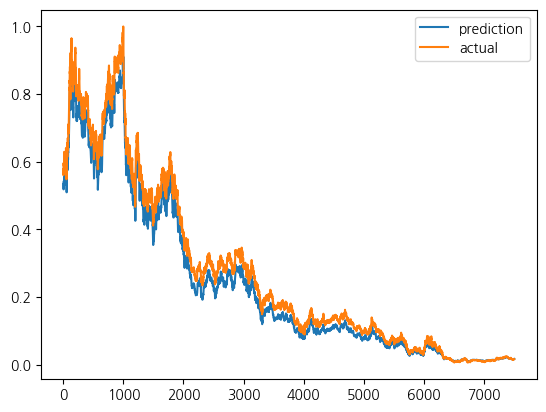

In [123]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()